# Visualise distribution of Computational Neuroscience around the globe

## Install dependencies

In [1]:
!python -m pip install --quiet -r requirements.txt
%load_ext autoreload
%autoreload 2

## Imports

In [2]:
%matplotlib notebook
import sys
assert sys.version_info.major>=3 and sys.version_info.minor>=6, "must be version >= 3.6 for format string literals and requests-xml"
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from requests_xml import XMLSession
requests = XMLSession()

## Figure settings

In [3]:
from matplotlib import rcParams

class settings:
    SMALLEST_SIZE = 6
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    LARGE_SIZE = 12
    BIGGER_SIZE = 14
    BIGGEST_SIZE = 18
    FIG_SIZE = (16, 10)
    FIG_RES_ADJUST = 1  # or 4 for 4K

def set_figure_dpi(dpi=None, figure_formats=['png2x']):
    """Set resolution and format of figures.

    Parameters
    ----------
    dpi : int, optional
        Resolution of png output in dots per inch.
    figure_formats : list of strings
        Only concerns the IPython environment; see
        `IPython.core.display.set_matplotlib_formats` for more details. For
        setting the default format for saving figures, directly set
        `file_format_figs`.
    """
    try:
        import matplotlib_inline
        matplotlib_inline.backend_inline.set_matplotlib_formats(*figure_formats)
    except:
        pass
    global _dpi
    if dpi is not None: _dpi = dpi
    # need to set the following two lines as older Jupyter notebooks seem to use
    # 'savefig.dpi' and more rescent ones 'figure.dpi'
    rcParams['savefig.dpi'] = _dpi
    rcParams['figure.dpi'] = _dpi

rcParams['pdf.fonttype'] = 42  # Output Type 3 (Type3) or Type 42 (TrueType)
plt.rc('font', family='sans serif', size=settings.MEDIUM_SIZE)  # controls default text sizes
rcParams['axes.titlesize'] = settings.BIGGEST_SIZE  # fontsize of the axes title
rcParams['axes.labelsize'] = settings.BIGGEST_SIZE  # fontsize of the x and y labels
rcParams['xtick.labelsize'] = settings.BIGGER_SIZE  # fontsize of the tick labels
rcParams['ytick.labelsize'] = settings.LARGE_SIZE  # fontsize of the tick labels
rcParams['legend.fontsize'] = settings.BIGGEST_SIZE  # legend fontsize
rcParams['figure.titlesize'] = settings.BIGGEST_SIZE  # fontsize of the figure title
rcParams['axes.linewidth'] = 2
rcParams['xtick.major.size'] = 10
rcParams['xtick.major.width'] = 2
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.width'] = 1
set_figure_dpi(settings.FIG_RES_ADJUST * rcParams['figure.dpi'])

## Define search terms

In [4]:
all_comp_search_term = '(computational OR mathematical OR theoretical) AND neuroscience'.replace(" ","+")
all_neuro_search_term = 'neuroscience'

## Load country codes from a csv file

data is from https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes

In [5]:
country_codes = pd.read_csv("https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/raw/master/all/all.csv")
# fix NAMIBIA and USA
country_codes = country_codes.fillna("NA")
# USA exception: https://www.nlm.nih.gov/bsd/mms/medlineelements.html#ad
country_codes['alpha-2'] = country_codes['alpha-2'].replace('US','USA')

country_codes['name'] = country_codes['name'].replace('United States of America','USA')
country_codes['name'] = country_codes['name'].replace('United Kingdom of Great Britain and Northern Ireland',
                                                      'UK')
country_codes['name'] = country_codes['name'].replace("Lao People's Democratic Republic","Laos")
# remove parentheses
country_codes['name'] = country_codes['name'].str.replace(r"\(.*\)","")
country_codes

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NA,142.0,34.0,NA
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NA,150.0,154.0,NA
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NA,150.0,39.0,NA
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NA,2.0,15.0,NA
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NA,9.0,61.0,NA
...,...,...,...,...,...,...,...,...,...,...,...
244,Wallis and Futuna,WF,WLF,876,ISO 3166-2:WF,Oceania,Polynesia,NA,9.0,61.0,NA
245,Western Sahara,EH,ESH,732,ISO 3166-2:EH,Africa,Northern Africa,NA,2.0,15.0,NA
246,Yemen,YE,YEM,887,ISO 3166-2:YE,Asia,Western Asia,NA,142.0,145.0,NA
247,Zambia,ZM,ZMB,894,ISO 3166-2:ZM,Africa,Sub-Saharan Africa,Eastern Africa,2.0,202.0,14.0


## Function to get number of results from PubMed for a given search term

In [6]:
import time
from typing import Optional

from tqdm import tqdm

base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term="

def get_number_results_from_pubmed(base_search_term, country_name=None, pbar: Optional[tqdm]=None, max_tries=10, _num_tries=0):
    try:
        if country_name is None:
            result = requests.get(f'{base_url}{base_search_term}')
        else:
            result = requests.get(f'{base_url}{base_search_term}+AND+("{country_name}"[ad]')
    except Exception as e:
        if _num_tries>=max_tries:
            raise
        else:
            if pbar is None:
                print(_num_tries, end=' ')
            else:
                pbar.set_description(f"{pbar.desc}! retrying ({_num_tries+1}/{max_tries})")
            time.sleep(1) # pause for 1 sec
            return get_number_results_from_pubmed(base_search_term, 
                                                  country_name=country_name, 
                                                  _num_tries=_num_tries+1)
    assert result.status_code == 200, print(result.status_code, result.text)
    return int(result.xml.xpath("//eSearchResult//Count", first=True).text)
# test it works
r = get_number_results_from_pubmed(all_comp_search_term,"South Africa")
print(f"Number of publications from South Africa is *{r}*")

Number of publications from South Africa is *310*


## Iterate through countries to get their counts

In [7]:
overwrite = False # ignores presence of file
max_tries = 10
file_name = "comp_neuro_viz_data.csv"

file_exists = os.path.exists(file_name) and not overwrite

if file_exists:
    print("reading from file")
    df = pd.read_csv(file_name, index_col=0)
else:
    print("retrieving from pubmed")
    values = country_codes[['name','alpha-2']].sort_values(by='alpha-2').values
    df = pd.DataFrame({'name':country_codes['name'].values},
                      columns=['name','count_cn','count_neuro'],
                      index=country_codes['alpha-2'])
    with tqdm(values) as pbar:
        for name, short in pbar:
            pbar.set_description(f"Retrieving [{short}] {name:30s}")
            df.loc[short,'region'] = country_codes[country_codes['alpha-2']==short].region.values[0]
            df.loc[short,'count_cn'] = get_number_results_from_pubmed(all_comp_search_term, name, pbar=pbar, max_tries=max_tries)
            df.loc[short,'count_neuro'] = get_number_results_from_pubmed(all_neuro_search_term, name, pbar=pbar, max_tries=max_tries)
        pbar.set_description(f"Retrieving total")
        df.loc['total','count_cn'] = get_number_results_from_pubmed(all_comp_search_term, pbar=pbar, max_tries=max_tries)
        df.loc['total','count_neuro'] = get_number_results_from_pubmed(all_neuro_search_term, pbar=pbar, max_tries=max_tries)
    df.to_csv(file_name)
    print("done")
total_cn = df.loc['total','count_cn']
total_neuro = df.loc['total','count_neuro']
df = df.drop(['total'])
df = df.drop(labels=['JE','MF','SX','GE']) # drop no flags (and US States [JE,GE])


reading from file


## Some cleaning

In [8]:
# Nambia code is na, which is a pandas keyword, so rename
df = df.rename(index={np.nan:'NA'})
# sort by country code
df = df.sort_index()
# drop zeros
truthy = (df==0).any(axis=1)
countries_with_no_cn = df.loc[truthy]
df = df.loc[~truthy]
df

,name,count_cn,count_neuro,region
alpha-2,,,,
AD,Andorra,1,9,Europe
AE,United Arab Emirates,111,608,Asia
AF,Afghanistan,3,21,Asia
AG,Antigua and Barbuda,2,15,Americas
AI,Anguilla,1,2,Americas
...,...,...,...,...
WS,Samoa,1,3,Oceania
YE,Yemen,5,38,Asia
ZA,South Africa,310,2420,Africa


## Some basic arithmetic

In [9]:
summed = df[['count_cn','count_neuro']].sum()
total_cn_sum = summed['count_cn']
total_neuro_sum = summed['count_neuro']

# print(df)
df['cn vs neuro'] = 100*df['count_cn']/(df['count_neuro'])
df['cn vs world'] = 100*df['count_cn']/total_cn
df['neuro vs world'] = 100*df['count_neuro']/total_neuro
df['cn vs neuro vs world'] = df['cn vs neuro'] / (total_cn/total_neuro)
world_cn_v_neuro = 100*total_cn/total_neuro
print(f"""Percentage of Neuroscience that is Computational Neuroscience (for world) = {world_cn_v_neuro:.2f}%
total Comp Neuro
    from search = {total_cn}
    from sum    = {total_cn_sum}
total Neuro
    from search = {total_neuro}
    from sum    = {total_neuro_sum}""")
print("Example data for South Africa (ZA)")
df.loc['ZA']

Percentage of Neuroscience that is Computational Neuroscience (for world) = 10.72%
total Comp Neuro
    from search = 60923
    from sum    = 96305
total Neuro
    from search = 568394
    from sum    = 747076
Example data for South Africa (ZA)


name                    South Africa
count_cn                         310
count_neuro                     2420
region                        Africa
cn vs neuro                12.809917
cn vs world                 0.508839
neuro vs world              0.425761
cn vs neuro vs world       119.51283
Name: ZA, dtype: object

## Pie plots

**WARNING**

from http://python-graph-gallery.com/pie-plot/

> Pie chart is easily the worst way to convey information ever developed in the history of data visualization. Thus, it must be avoided and replaced with barplot most of the time. Indeed, it is really difficult for a human to make the difference between the size of similar slices. 

array([<Axes: ylabel='count_cn'>, <Axes: ylabel='count_neuro'>],
      dtype=object)

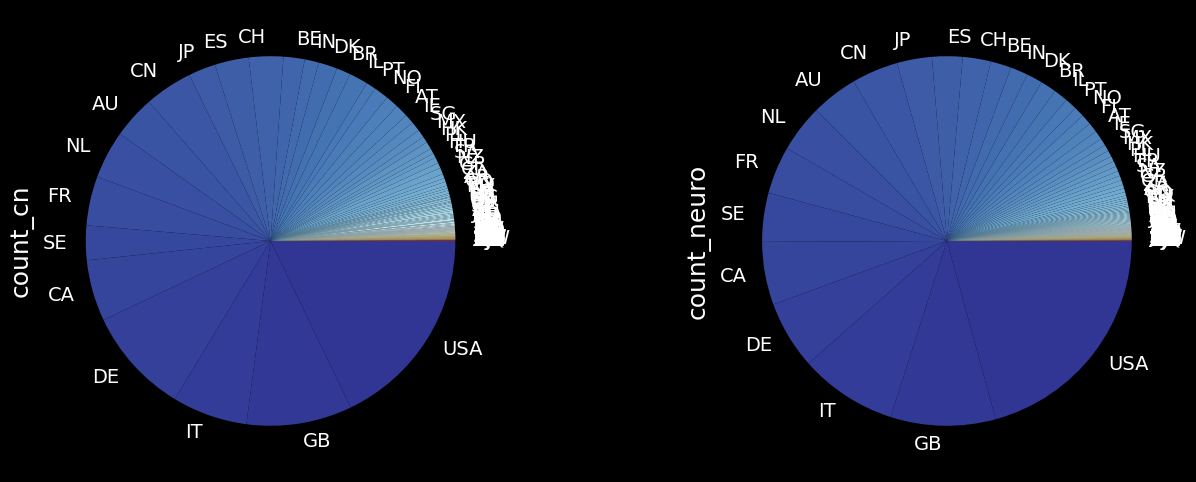

In [10]:
%matplotlib inline
df[['count_cn','count_neuro']] \
    .sort_values(by=['count_neuro','count_cn']) \
    .plot(kind='pie', subplots=True, figsize=(16, 6),legend=False,cmap=plt.get_cmap("RdYlBu"))

### Sort by Computational Neuroscience output

In [11]:
df.sort_values(by='count_cn',ascending=False).head(10)

,name,count_cn,count_neuro,region,cn vs neuro,cn vs world,neuro vs world,cn vs neuro vs world
alpha-2,,,,,,,,
USA,USA,17199,154977,Americas,11.097776,28.230717,27.265770,103.539044
DE,Germany,8964,44475,Europe,20.155143,14.713655,7.824678,188.041668
GB,UK,8891,68637,Europe,12.953655,14.593832,12.075602,120.853859
IT,Italy,6338,63785,Europe,9.936505,10.403296,11.221969,92.704727
CA,Canada,5152,41095,Americas,12.536805,8.456576,7.230020,116.964771
FR,France,4127,31170,Europe,13.240295,6.774125,5.483872,123.528131
NL,Netherlands,4046,30859,Europe,13.111248,6.641170,5.429157,122.324158
CN,China,4035,30412,Asia,13.267789,6.623114,5.350514,123.784641
AU,Australia,3591,30492,Oceania,11.776860,5.894326,5.364589,109.874699


### Sort by Neuroscience output

In [12]:
# total count
df['count'] = df['count_cn']+df['count_neuro']
# persist the sort
df = df.sort_values(by=['count_neuro','count_cn'])
df.head(10)

,name,count_cn,count_neuro,region,cn vs neuro,cn vs world,neuro vs world,cn vs neuro vs world,count
alpha-2,,,,,,,,,
TW,"Taiwan, Province of China",1,1,Asia,100.000000,0.001641,0.000176,932.971127,2
AI,Anguilla,1,2,Americas,50.000000,0.001641,0.000352,466.485564,3
IR,Iran (Islamic Republic of),1,2,Asia,50.000000,0.001641,0.000352,466.485564,3
TM,Turkmenistan,1,2,Asia,50.000000,0.001641,0.000352,466.485564,3
DM,Dominica,1,3,Americas,33.333333,0.001641,0.000528,310.990376,4
TJ,Tajikistan,1,3,Asia,33.333333,0.001641,0.000528,310.990376,4
WS,Samoa,1,3,Oceania,33.333333,0.001641,0.000528,310.990376,4
BT,Bhutan,2,3,Asia,66.666667,0.003283,0.000528,621.980752,5
BS,Bahamas,1,5,Americas,20.000000,0.001641,0.000880,186.594225,6


## Lollipop graphs

flag not found: cw - Curaçao
flag not found: np - Nepal


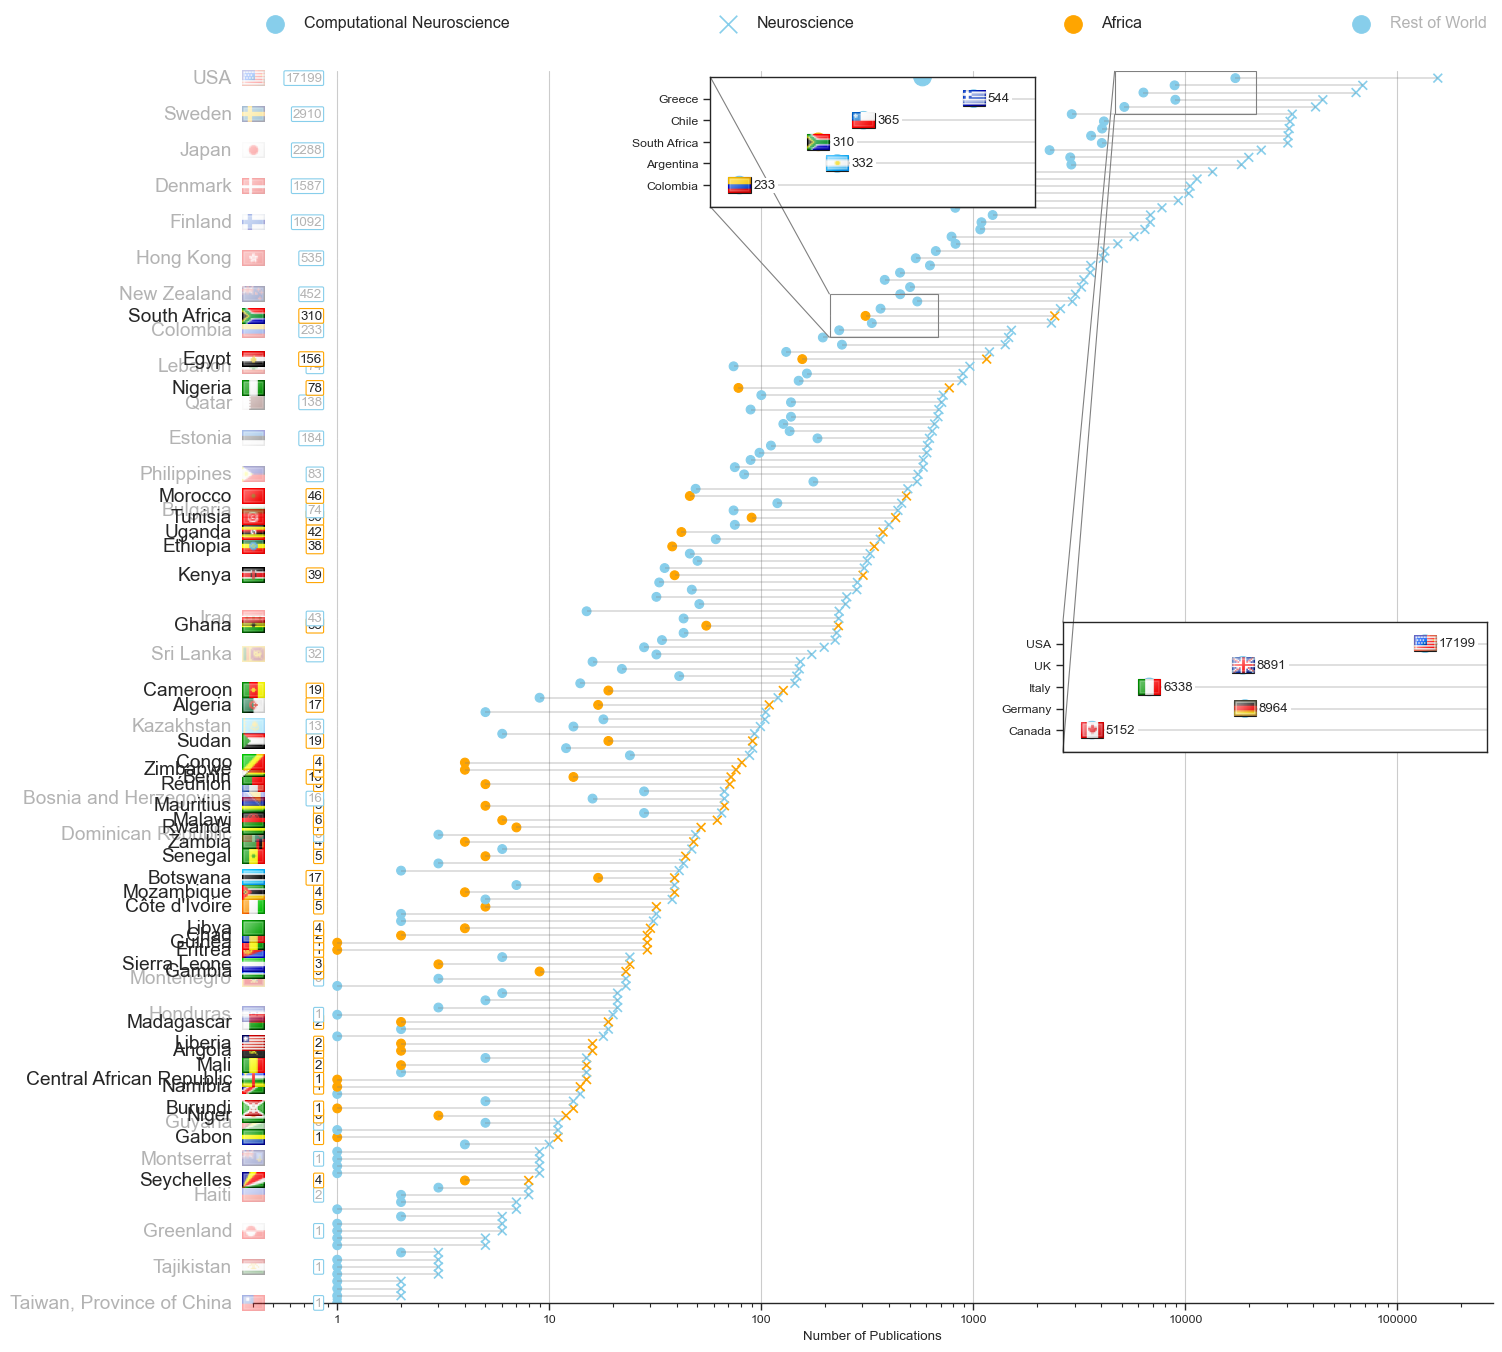

In [14]:
%matplotlib inline
plt.style.use("default")
sns.set_theme(context="paper", style="ticks")

from lollipop import plot_lollipop

df = df.sort_values(by=['count_neuro','count_cn'])

# make it neater by removing some countries 
# (by default all African countries and every 3rd of the others are shown)
step = 5
initial = list(np.where(df['region']=='Africa')[0])
start, stop = 0, df.index.size
labels = list(set(list(range(start, stop, step))+initial))
remove=[]
tmp_df = df.copy()
tmp_df['i'] = range(len(df))
tmp_df = tmp_df.iloc[labels]
tmp_df = tmp_df[~tmp_df['name'].isin(remove)]
labels = tmp_df['i'].values

sa_index = np.where(df.index=="ZA")[0][0]

plot_lollipop(df[df['count_neuro']>0],
                figsize=(16,16),
                hlines=True,
                num_in_zoom=5,
                indices=[sa_index, 0],
                labels=labels,
                bold_labels=initial)
for fmt in ["svg", "jpg"]:
        plt.savefig(f"graph.{fmt}", dpi='figure', transparent=False, 
                orientation='portrait', 
                format=None,
                bbox_inches='tight', pad_inches=0.1, 
                )
plt.show()

## Visualise as World Map

In [15]:
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.io import show, export_svgs, output_notebook

country_xs = []
country_ys = []
country_names = []
country_cn = []
country_neuro = []

r = requests.get('https://raw.githubusercontent.com/datasets/geo-boundaries-world-110m/master/countries.geojson')
geodata = r.json()
geodata_features = geodata['features']
for i,aCountry in enumerate(geodata_features):
    cName = aCountry['properties']['name']
    if cName == 'Antarctica':
        continue
    alpha2 = aCountry['properties']['wb_a2']
    if alpha2=='US':
        alpha2="USA"
    if alpha2 in df.index.values:
        counts = df.loc[alpha2,['count_cn','count_neuro']]
        count_cn = counts['count_cn']
        count_neuro = counts['count_neuro']
    else:
        count_cn = count_neuro = 0
    
    geometry_type = aCountry['geometry']['type']
    if geometry_type == "MultiPolygon":
        for poly_coords in aCountry['geometry']['coordinates']:
            coords = poly_coords[0]
            country_xs.append(list(map(lambda x:x[0],coords)))
            country_ys.append(list(map(lambda x:x[1],coords)))
            country_cn.append(count_cn)
            country_neuro.append(count_neuro)
            country_names.append(cName)
    else:
        coords = aCountry['geometry']['coordinates'][0]
        country_xs.append(list(map(lambda x:x[0],coords)))
        country_ys.append(list(map(lambda x:x[1],coords)))
        country_cn.append(count_cn)
        country_neuro.append(count_neuro)
        country_names.append(cName)
    
source = ColumnDataSource(
    data = dict(
        x=country_xs,
        y=country_ys,
        name=country_names,
        count_cn=country_cn,
        count_neuro=country_neuro,
    )
)
output_notebook()

Loading BokehJS ...

In [16]:
high = df['count_cn'].max()
yticks = np.logspace(0,np.log1p(high),3,base=np.e)
yticklabels = [f"{ytick:.0f}" for ytick in yticks]
yticklabels[0] = '0'
yticklabels[-1] = str(high)
yticklabels

['0', '131', '17199']

In [17]:
from bokeh.models import (BasicTicker, ColorBar, HoverTool, Label,
                          LogColorMapper)
from matplotlib import colors

# number of distinct colors (excluding white)
n = 100
cm = plt.get_cmap('Greens',n)
# convert to hex
palette = [colors.rgb2hex(cm(i)) for i in range(cm.N)]
palette.insert(0,'#ffffff')

TOOLS="pan,wheel_zoom,box_zoom,reset,hover,save"
p = figure(height=400,width=1000, toolbar_location='above')
color_mapper = LogColorMapper(palette=palette, low=0.1, high=high) # includes 0

p.patches('x', 'y', source=source,
          fill_color={'field': 'count_cn', 'transform': color_mapper},
          fill_alpha=1, line_color="black", line_width=0.5,
          hover_fill_alpha = 0.5)

hover = HoverTool(tooltips=[
    ('Name', '@name'),
    ('Computational Neuroscience', '@count_cn'),
    ('Neuroscience', '@count_neuro'),
                                   ])

p.add_tools(hover)

cbar_height = 150
color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(desired_num_ticks=0), 
                     border_line_color=None, 
                     label_standoff=14,major_label_text_align='right',
                     major_tick_line_color='black',
                     height=cbar_height, width=50, location=(35,10))
p.add_layout(color_bar)


# labels for the colorbar won't be added because color_mapper includes 0, and this is easier to customise
y_base = 1
dheight = cbar_height/(len(yticklabels)-1)
for i,yticklabel in enumerate(yticklabels):
    color_bar_axis = Label(x=93, y=y_base+i*dheight, x_units='screen', y_units='screen',
                         text='- '+yticklabel, text_font='sans serif', text_font_size=f"{settings.BIGGEST_SIZE+8}pt")
    p.add_layout(color_bar_axis)

p.outline_line_color = None
p.xaxis.visible = False
p.yaxis.visible = False 
p.xgrid.visible = False
p.ygrid.visible = False
p.background_fill_color = None
p.border_fill_color = None
show(p)

### Save map

In [18]:
p.output_backend = "svg"
export_svgs(p, filename="choropeth.svg")

['choropeth.svg']

### Combine figures

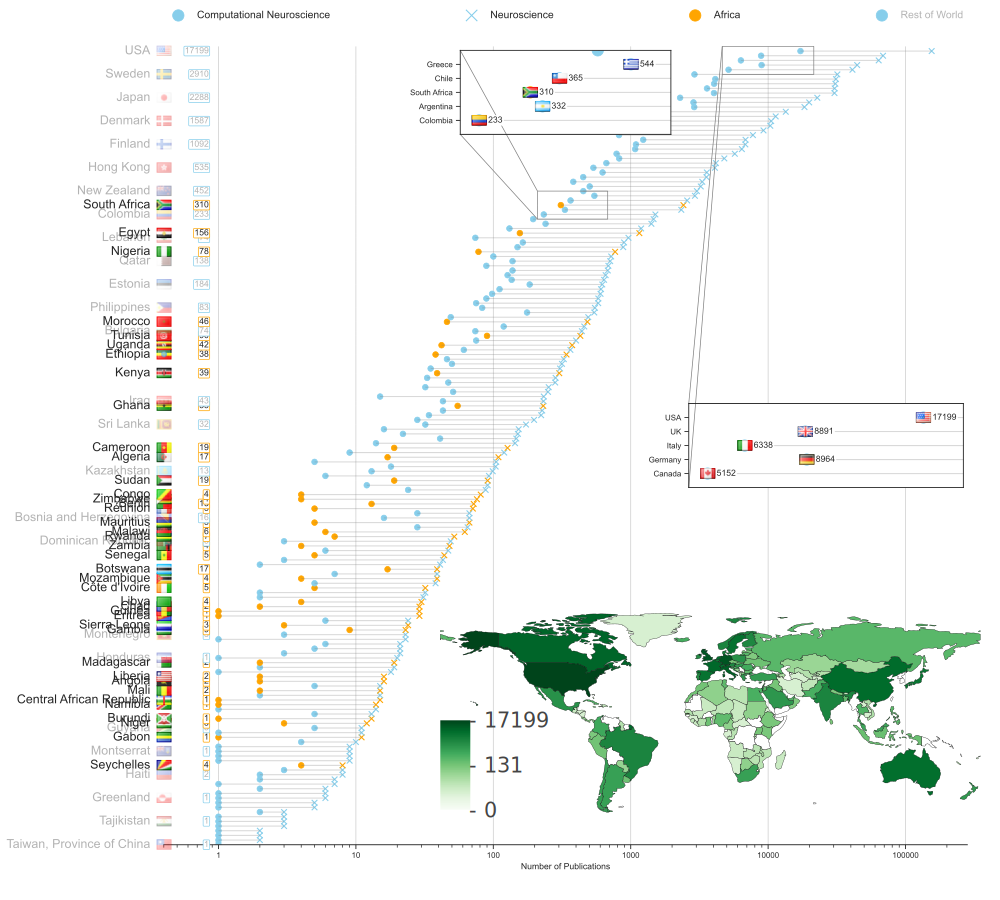

In [19]:
import svgutils.compose as sc
from IPython.display import SVG # /!\ note the 'SVG' function also in svgutils.compose
sc.Figure("1000", "900", 
    sc.Panel(sc.SVG("graph.svg").scale(0.9).move(0,0)),
    sc.Panel(sc.SVG("choropeth.svg").scale(.6).move(410,585)),
    ).save("figure_1.svg")
SVG('figure_1.svg')